# Ingest and View Data

In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [2]:
POSTGRES_USERNAME = 'root'
POSTGRES_PASSWORD = 'koBREipm4h7CuRKix2Tn'
POSTGRES_HOSTNAME = 'database-1.c3ma8u2guxxs.us-east-2.rds.amazonaws.com'
POSTGRES_PORT = '5432'
POSTGRES_DBNAME = 'postgres'

connection_string = f"postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_HOSTNAME}:{POSTGRES_PORT}/{POSTGRES_DBNAME}"
engine = create_engine(connection_string)

In [3]:
query = """
SELECT * FROM darwin
"""

df = pd.read_sql(query, engine)

In [4]:
df.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_pass,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,...,platform,train_length,estimated_time,source,actual_time,actual_time_class,is_delayed_arrival,is_delayed_departure,source_instance,estimated_time_minutes
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,None,19:31:00,19:31:30,19:31:00,19:31:00,...,4,10.0,None,None,None,None,False,False,None,None
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,None,19:37:00,19:38:00,19:37:00,19:38:00,...,A,NaN,None,None,None,None,False,False,None,None
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,None,19:30:30,19:31:00,19:31:00,19:31:00,...,2,NaN,None,None,None,None,False,False,None,None
3,202407036735756,C35756,2024-07-03,TD,BRMB,None,19:33:00,19:33:30,19:33:00,19:33:00,...,1,NaN,None,None,None,None,False,False,None,None
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,None,19:35:00,19:35:30,19:35:00,19:35:00,...,2,NaN,None,None,None,None,False,False,None,None


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282817 entries, 0 to 282816
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   route_id                282817 non-null  object 
 1   unique_id               282817 non-null  object 
 2   service_start_date      282817 non-null  object 
 3   update_origin           275807 non-null  object 
 4   train_platform          282817 non-null  object 
 5   working_time_pass       0 non-null       object 
 6   working_time_arrival    282817 non-null  object 
 7   working_time_departure  282817 non-null  object 
 8   planned_time_arrival    259108 non-null  object 
 9   planned_time_departure  258195 non-null  object 
 10  actual_arrival_time     238217 non-null  object 
 11  actual_departure_time   264681 non-null  object 
 12  platform                265003 non-null  object 
 13  train_length            94191 non-null   float64
 14  estimated_time      

# Clean DF 
**Drop Null Columns and Unnecessary Columns**

In [6]:
# columns to drop due to null values
columns_to_drop = [
    'working_time_pass',
    'estimated_time',
    'source',
    'actual_time',
    'actual_time_class',
    'source_instance',
    'estimated_time_minutes',
    'train_length'            
]

df_cleaned = df.drop(columns=columns_to_drop)

In [7]:
# check duplicates
duplicates = df_cleaned.duplicated().sum()
duplicates

8929

In [8]:
# to drop duplicates
df_cleaned = df_cleaned.drop_duplicates()

In [9]:
# check nulls
df_cleaned.isna().sum()

route_id                      0
unique_id                     0
service_start_date            0
update_origin              6210
train_platform                0
working_time_arrival          0
working_time_departure        0
planned_time_arrival      23546
planned_time_departure    24243
actual_arrival_time       44512
actual_departure_time     17889
platform                  17425
is_delayed_arrival            0
is_delayed_departure          0
dtype: int64

In [10]:
# to drop remaining nulls
# df_cleaned = df_cleaned.dropna()

# Create Delay DF

In [11]:
query_delay = "SELECT * FROM darwin WHERE is_delayed_arrival = True AND is_delayed_departure = True"
df_delay = pd.read_sql(query_delay, engine)

In [12]:
df_delay = df_delay.drop(columns=columns_to_drop)

In [13]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30879 entries, 0 to 30878
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   route_id                30879 non-null  object
 1   unique_id               30879 non-null  object
 2   service_start_date      30879 non-null  object
 3   update_origin           30869 non-null  object
 4   train_platform          30879 non-null  object
 5   working_time_arrival    30879 non-null  object
 6   working_time_departure  30879 non-null  object
 7   planned_time_arrival    15974 non-null  object
 8   planned_time_departure  15918 non-null  object
 9   actual_arrival_time     30856 non-null  object
 10  actual_departure_time   30800 non-null  object
 11  platform                22391 non-null  object
 12  is_delayed_arrival      30879 non-null  bool  
 13  is_delayed_departure    30879 non-null  bool  
dtypes: bool(2), object(12)
memory usage: 2.9+ MB


In [14]:
df_delay.duplicated().sum()

124

# Adding Duration Column
Convert times from object datatypes to time datatypes.

In [15]:
df_cleaned['working_time_arrival'] = pd.to_datetime(df_cleaned['working_time_arrival'], format='%H:%M:%S')
df_cleaned['working_time_departure'] = pd.to_datetime(df_cleaned['working_time_departure'], format='%H:%M:%S')

Complete math to find duration.

In [16]:
df_cleaned['duration (min)'] = ((df_cleaned['working_time_departure']-df_cleaned['working_time_arrival'])\
                                .dt.total_seconds()/60)

Transition back to time only.

In [17]:
df_cleaned['working_time_arrival'] = df_cleaned['working_time_arrival'].dt.time
df_cleaned['working_time_departure'] = df_cleaned['working_time_departure'].dt.time

Repeat for Delay Dataframe.

In [18]:
df_delay['working_time_arrival'] = pd.to_datetime(df_delay['working_time_arrival'], format='%H:%M:%S')
df_delay['working_time_departure'] = pd.to_datetime(df_delay['working_time_departure'], format='%H:%M:%S')
df_delay['duration (min)'] = ((df_delay['working_time_departure']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)
df_delay['working_time_arrival'] = df_delay['working_time_arrival'].dt.time
df_delay['working_time_departure'] = df_delay['working_time_departure'].dt.time

In [19]:
# Check for zero and negative values
neg_zero_duration_counts = df_cleaned[df_cleaned['duration (min)'] <= 0]['duration (min)'].value_counts().sort_index(ascending=True)

# Display the result
print(neg_zero_duration_counts)

duration (min)
-1438.5       8
-1438.0      13
-1437.5       7
-1437.0      21
-1436.0      47
-1435.0      16
-1434.5       1
-1434.0      20
-1433.0       9
-1432.0      17
-1431.0       7
-1430.0      47
-1429.5       2
-1429.0       1
-1427.0       5
-1426.0       1
-1420.0       3
-1419.0       8
-1418.0       3
-1406.5       1
-1401.0      13
-1395.0       8
-1313.5       6
-1310.5       1
-1272.5       2
 0.0       3913
Name: count, dtype: int64


In [20]:
# Drop the rows with negative values in duration
df_cleaned = df_cleaned[df_cleaned['duration (min)'] > 0]

In [21]:
# Check
neg_zero_duration_counts = df_cleaned[df_cleaned['duration (min)'] <= 0]['duration (min)'].value_counts().sort_index(ascending=True)

# Display the result
print(neg_zero_duration_counts)

Series([], Name: count, dtype: int64)


In [22]:
# Repeating Drop for delay_df to remove negative values in duration

df_delay = df_delay[df_delay['duration (min)'] > 0]

## Adding a Day of the Week Column

In [23]:
df_cleaned['service_start_date'] = pd.to_datetime(df_cleaned['service_start_date'])
df_cleaned['weekday'] = df_cleaned['service_start_date'].dt.day_name()

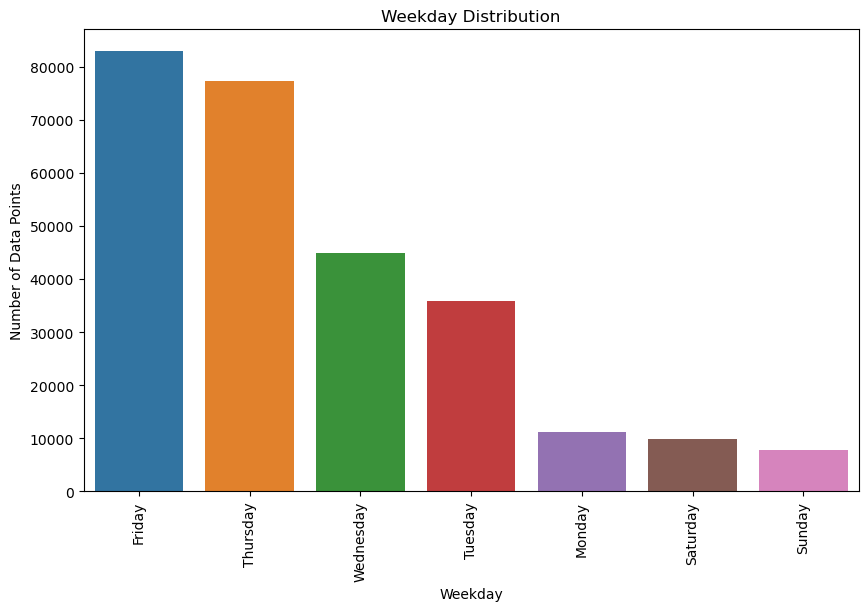

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
# Top 10 most frequently visited stations
weekday_dist = df_cleaned['weekday'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=weekday_dist.index, y=weekday_dist.values)
plt.title('Weekday Distribution')
plt.xlabel('Weekday')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=90)
plt.show()

Keeping an eye on this distribtuion to try and keep data even across each weekday.

In [25]:
df_delay['service_start_date'] = pd.to_datetime(df_delay['service_start_date'])
df_delay['weekday'] = df_delay['service_start_date'].dt.day_name()

# Ingest Rail References Data

In [26]:
reference_df = pd.read_csv('./raw_data/RailReferences.csv')

## Convert Easting, Northing to Latitude and Longitude

In [27]:
!pip install pyproj

In [28]:
from pyproj import Transformer

In [29]:
#  Define the British National Grid projection (EPSG:27700) and WGS84
osgb_projection = 'epsg:27700'  # British National Grid
wgs84_projection = 'epsg:4326'  # WGS84

In [30]:
# Initialize the transformer
transformer = Transformer.from_crs(osgb_projection, wgs84_projection)

In [31]:
# Function to convert British National Grid to latitude and longitude
def convert_osgb_to_latlong(easting, northing):
    longitude, latitude = transformer.transform(easting, northing)
    return longitude, latitude

In [32]:
# Apply conversion to the DataFrame and create new columns Latitude and Longitude
reference_df[['Latitude', 'Longitude']] = reference_df.apply(lambda row: convert_osgb_to_latlong(row['Easting'], row['Northing']),\
                                         axis=1,\
                                         result_type='expand')

In [33]:
# Data need for analysis 
data = reference_df[['TiplocCode', 'StationName', 'Latitude', 'Longitude']]
data

,TiplocCode,StationName,Latitude,Longitude
0,PENZNCE,Penzance Rail Station,50.121672,-5.532565
1,STIVES,St Ives (Cornwall) Rail Station,50.209043,-5.477912
2,CARBISB,Carbis Bay Rail Station,50.197048,-5.463263
3,STERTH,St Erth Rail Station,50.170489,-5.444252
4,LELANTS,Lelant Saltings Rail Station,50.178775,-5.440926
...,...,...,...,...
2623,SMRLYTN,Somerleyton Rail Station,52.510229,1.652260
2624,OULTNBS,Oulton Broad South Rail Station,52.469602,1.707659
2625,YARMTH,Great Yarmouth Rail Station,52.612158,1.720886
2626,OULTNBN,Oulton Broad North Rail Station,52.477759,1.715711


### Data Enrichment
Used this section to add identifying information for top Timing Point Locations (*TiplocCode*) not already identified in the supplied "RailReferences.csv" data. 

Research indicates that the Timing Point Location for BONDST, correlates to Bond Street Station$^{1}$ located at 51.514°N, 0.15°W$^{2}$. 

In [34]:
new_row = pd.DataFrame([['BONDST', 'Bond Street Station', 51.514, -0.15]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for TOTCTRD, correlates to Tottenham Court Road$^{1}$ located at 51.5207°N, 0.1345°W$^{3}$. 

In [35]:
new_row = pd.DataFrame([['TOTCTRD', 'Tottenham Court Road', 51.5207, -0.1345]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for CANWHRF, correlates to Canary Wharf Railway Station$^{1}$ located at 51.5061°N, 0.01578°W$^{4}$. 

In [36]:
new_row = pd.DataFrame([['CANWHRF', 'Canary Wharf Railway Station', 51.5061, -0.01578]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for WCHAPXR, correlates to Whitechapel Crossrail$^{1}$ located at 51.5195°N, 0.0612°W$^{5, 6}$. 

In [37]:
new_row = pd.DataFrame([['WCHAPXR', 'Whitechapel Crossrail', 51.9195, -0.0612]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for LIVSTLL, correlates to London Liverpool Street Crossrail$^{1}$ located at 51.5186°N, 0.0813°W$^{6, 7}$. 

In [38]:
new_row = pd.DataFrame([['LIVSTLL', 'London Liverpool Street Crossrail', 51.5186, -0.0813]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

### Bibliography

1. http://www.railwaycodes.org.uk/crs/crsb.shtm

2. https://en.wikipedia.org/wiki/Bond_Street_station

3. https://en.wikipedia.org/wiki/Tottenham_Court_Road

4. https://en.wikipedia.org/wiki/Canary_Wharf_railway_station

5. https://en.wikipedia.org/wiki/Whitechapel_station

6. https://en.wikipedia.org/wiki/Crossrail

7. https://en.wikipedia.org/wiki/Liverpool_Street_station

## Using Rail References to Replace Train Platform with Station Name

In [39]:
# Merge df_cleaned with data columns from reference_df

df_merged = df_cleaned.merge(data, left_on='train_platform', right_on='TiplocCode', how='left')

In [40]:
# checking where train_platform has no related StationName/Tiploccode
nan_rows = df_merged[df_merged[['TiplocCode', 'StationName']].isna().any(axis=1)]

nan_rows[['train_platform', 'TiplocCode', 'StationName']]

,train_platform,TiplocCode,StationName
16,WOLWXR,NaN,NaN
23,FRMPKRS,NaN,NaN
24,HRNS451,NaN,NaN
25,BOWERRL,NaN,NaN
52,CMRNBDG,NaN,NaN
...,...,...,...
269396,NPLE813,NaN,NaN
269402,DORK35,NaN,NaN
269491,PRNCSTG,NaN,NaN
269583,MWRWSTN,NaN,NaN


In [41]:
# Identifying most highly frequented unknown Station Names
station_NaN = df_merged[df_merged['StationName'].isna()]['train_platform'].value_counts()
station_NaN.head(20)

train_platform
FRNDXR     685
PADTLL     441
CUSTMHS    394
WOLWXR     379
BRENTX     336
STALBCS    327
MAGHNTH    216
PALL       209
MLLF       206
CNNBELL    197
SHLDNO1    191
UNIV       191
CIVI       191
STDI       185
FELL       166
PELAWTW    142
ASHFDYW    137
CRKLREC    136
EBSFLTI    134
BOWERRL    130
Name: count, dtype: int64

In [42]:
# fill NaN values in the StationName column with the corresponding train_platform values
df_merged['StationName'] = df_merged['StationName'].fillna(df_merged['train_platform'])

# Replace 'Rail Station' with an empty string to make more readable
df_merged['StationName'] = df_merged['StationName'].str.replace(' Rail Station', '')

In [43]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269708 entries, 0 to 269707
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   route_id                269708 non-null  object        
 1   unique_id               269708 non-null  object        
 2   service_start_date      269708 non-null  datetime64[ns]
 3   update_origin           263526 non-null  object        
 4   train_platform          269708 non-null  object        
 5   working_time_arrival    269708 non-null  object        
 6   working_time_departure  269708 non-null  object        
 7   planned_time_arrival    248113 non-null  object        
 8   planned_time_departure  247415 non-null  object        
 9   actual_arrival_time     225568 non-null  object        
 10  actual_departure_time   251924 non-null  object        
 11  platform                255214 non-null  object        
 12  is_delayed_arrival      269708

## Adding a Day of the Wek Column

# Delays

In [44]:
df_delay = df_delay.merge(data, left_on='train_platform', right_on='TiplocCode', how='left')

In [45]:
# fill NaN values in the StationName column with the corresponding train_platform values
df_delay['StationName'] = df_delay['StationName'].fillna(df_delay['train_platform'])

# Replace 'Rail Station' with an empty string to make more readable
df_delay['StationName'] = df_delay['StationName'].str.replace(' Rail Station', '')

In [85]:
df_delay.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,...,is_delayed_arrival,is_delayed_departure,duration (min),weekday,TiplocCode,StationName,Latitude,Longitude,depart_delay(min),arrive_delay(min)
0,202407037144581,G44581,2024-07-03,Darwin,GLOSTER,19:22:00,19:28:00,19:21:00,19:28:00,19:32:00,...,True,True,6.0,Wednesday,GLOSTER,Gloucester,51.865557,-2.238488,5.0,10.0
1,202407036707715,C07715,2024-07-03,Darwin,LADYBHL,19:24:00,19:35:30,None,None,19:33:00,...,True,True,11.5,Wednesday,NaN,LADYBHL,NaN,NaN,NaN,9.0
2,202407037154103,G54103,2024-07-03,Darwin,CRAWLEY,19:26:30,19:27:30,19:27:00,19:27:00,19:35:00,...,True,True,1.0,Wednesday,CRAWLEY,Crawley,51.112212,-0.186673,7.5,8.5
3,202407037154103,G54103,2024-07-03,Darwin,IFIELD,19:29:30,19:30:00,19:30:00,19:30:00,19:37:00,...,True,True,0.5,Wednesday,IFIELD,Ifield,51.115621,-0.214772,8.0,7.5
4,202407037154103,G54103,2024-07-03,Darwin,FAYGATE,19:33:30,19:34:00,19:34:00,19:34:00,19:41:00,...,True,True,0.5,Wednesday,FAYGATE,Faygate,51.095889,-0.263019,8.0,7.5


In [46]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29286 entries, 0 to 29285
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   route_id                29286 non-null  object        
 1   unique_id               29286 non-null  object        
 2   service_start_date      29286 non-null  datetime64[ns]
 3   update_origin           29276 non-null  object        
 4   train_platform          29286 non-null  object        
 5   working_time_arrival    29286 non-null  object        
 6   working_time_departure  29286 non-null  object        
 7   planned_time_arrival    15360 non-null  object        
 8   planned_time_departure  15304 non-null  object        
 9   actual_arrival_time     29263 non-null  object        
 10  actual_departure_time   29207 non-null  object        
 11  platform                22030 non-null  object        
 12  is_delayed_arrival      29286 non-null  bool  

Determine the minutes delayed.

In [47]:
df_delay['working_time_arrival'] = pd.to_datetime(df_delay['working_time_arrival'], format='%H:%M:%S')
df_delay['working_time_departure'] = pd.to_datetime(df_delay['working_time_departure'], format='%H:%M:%S')
df_delay['duration (min)'] = ((df_delay['working_time_departure']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)

In [48]:
df_delay['actual_arrival_time'] = pd.to_datetime(df_delay['actual_arrival_time'], format='%H:%M:%S')
df_delay['actual_departure_time'] = pd.to_datetime(df_delay['actual_departure_time'], format='%H:%M:%S')

In [49]:
df_delay['depart_delay(min)'] = ((df_delay['actual_departure_time']-df_delay['working_time_departure'])\
                                .dt.total_seconds()/60)

In [50]:
df_delay['arrive_delay(min)'] = ((df_delay['actual_arrival_time']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)

In [51]:
df_delay['working_time_arrival'] = df_delay['working_time_arrival'].dt.time
df_delay['working_time_departure'] = df_delay['working_time_departure'].dt.time
df_delay['actual_arrival_time'] = df_delay['actual_arrival_time'].dt.time
df_delay['actual_departure_time'] = df_delay['actual_departure_time'].dt.time

In [52]:
df_delay.describe()

,service_start_date,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,29286,29286.000000,22993.000000,22993.000000,29207.000000,29263.000000
mean,2024-07-09 18:01:41.782421248,3.355127,52.380984,-1.536613,-18.954780,-15.883454
min,2024-07-03 00:00:00,0.250000,50.170489,-5.444252,-1439.000000,-1436.500000
25%,2024-07-09 00:00:00,0.500000,51.519467,-3.002435,4.500000,6.000000
50%,2024-07-10 00:00:00,1.000000,51.684484,-1.547324,23.000000,25.000000
75%,2024-07-11 00:00:00,3.000000,53.399438,-0.212677,65.000000,67.500000
max,2024-07-12 00:00:00,247.000000,57.188510,1.715711,1434.000000,1438.000000
std,NaN,8.505878,1.277189,1.443980,287.018513,286.204009


We can see that the math in the previous step created some erroneous values (minimum of depart_delay(min) is negative.) This will occur in cases where there is no reported actual_departure_time or where the train arrived slightly early. We will get the value zero where the train is not delayed. We will define a function to null delays less than or equal to zero, because these are erroneous on not delays at all. 

In [53]:
def remove_neg_and_zero(delay):
    if delay <= 0:
        delay = None
    else:
        delay = delay
    return delay

In [54]:
df_delay['depart_delay(min)'] = df_delay['depart_delay(min)'].apply(remove_neg_and_zero)
df_delay['arrive_delay(min)'] = df_delay['arrive_delay(min)'].apply(remove_neg_and_zero)

In [55]:
df_delay.describe()

,service_start_date,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,29286,29286.000000,22993.000000,22993.000000,24857.000000,26414.000000
mean,2024-07-09 18:01:41.782421248,3.355127,52.380984,-1.536613,46.645442,46.218899
min,2024-07-03 00:00:00,0.250000,50.170489,-5.444252,0.500000,0.500000
25%,2024-07-09 00:00:00,0.500000,51.519467,-3.002435,10.000000,9.500000
50%,2024-07-10 00:00:00,1.000000,51.684484,-1.547324,34.500000,33.000000
75%,2024-07-11 00:00:00,3.000000,53.399438,-0.212677,72.000000,72.000000
max,2024-07-12 00:00:00,247.000000,57.188510,1.715711,1434.000000,1438.000000
std,NaN,8.505878,1.277189,1.443980,55.568573,56.691889


We can see that the are some erroneous high values for depart_delay(min) and arrive_delay(min). We will remove any values over 420minutes (7hrs), assuming those trains are rescheduled rather than delayed.

In [56]:
def remove_over_420(delay):
    if delay > 420:
        delay = None
    else:
        delay = delay
    return delay

In [57]:
df_delay['depart_delay(min)'] = df_delay['depart_delay(min)'].apply(remove_over_420)
df_delay['arrive_delay(min)'] = df_delay['arrive_delay(min)'].apply(remove_over_420)

In [58]:
df_delay.describe()

,service_start_date,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,29286,29286.000000,22993.000000,22993.000000,24838.000000,26393.000000
mean,2024-07-09 18:01:41.782421248,3.355127,52.380984,-1.536613,45.628362,45.153298
min,2024-07-03 00:00:00,0.250000,50.170489,-5.444252,0.500000,0.500000
25%,2024-07-09 00:00:00,0.500000,51.519467,-3.002435,10.000000,9.500000
50%,2024-07-10 00:00:00,1.000000,51.684484,-1.547324,34.000000,33.000000
75%,2024-07-11 00:00:00,3.000000,53.399438,-0.212677,72.000000,72.000000
max,2024-07-12 00:00:00,247.000000,57.188510,1.715711,257.500000,257.000000
std,NaN,8.505878,1.277189,1.443980,41.659900,42.271874


In [59]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29286 entries, 0 to 29285
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   route_id                29286 non-null  object        
 1   unique_id               29286 non-null  object        
 2   service_start_date      29286 non-null  datetime64[ns]
 3   update_origin           29276 non-null  object        
 4   train_platform          29286 non-null  object        
 5   working_time_arrival    29286 non-null  object        
 6   working_time_departure  29286 non-null  object        
 7   planned_time_arrival    15360 non-null  object        
 8   planned_time_departure  15304 non-null  object        
 9   actual_arrival_time     29263 non-null  object        
 10  actual_departure_time   29207 non-null  object        
 11  platform                22030 non-null  object        
 12  is_delayed_arrival      29286 non-null  bool  

In [60]:
# export delay routes csv
df_delay.to_csv('./cleaned_data/delay_durations.csv', index=False, mode = 'w+')

## Calculate Delay Duration
Take the data where we are able to calucate delays.

In [61]:
df_delay.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,...,is_delayed_arrival,is_delayed_departure,duration (min),weekday,TiplocCode,StationName,Latitude,Longitude,depart_delay(min),arrive_delay(min)
0,202407037144581,G44581,2024-07-03,Darwin,GLOSTER,19:22:00,19:28:00,19:21:00,19:28:00,19:32:00,...,True,True,6.0,Wednesday,GLOSTER,Gloucester,51.865557,-2.238488,5.0,10.0
1,202407036707715,C07715,2024-07-03,Darwin,LADYBHL,19:24:00,19:35:30,None,None,19:33:00,...,True,True,11.5,Wednesday,NaN,LADYBHL,NaN,NaN,NaN,9.0
2,202407037154103,G54103,2024-07-03,Darwin,CRAWLEY,19:26:30,19:27:30,19:27:00,19:27:00,19:35:00,...,True,True,1.0,Wednesday,CRAWLEY,Crawley,51.112212,-0.186673,7.5,8.5
3,202407037154103,G54103,2024-07-03,Darwin,IFIELD,19:29:30,19:30:00,19:30:00,19:30:00,19:37:00,...,True,True,0.5,Wednesday,IFIELD,Ifield,51.115621,-0.214772,8.0,7.5
4,202407037154103,G54103,2024-07-03,Darwin,FAYGATE,19:33:30,19:34:00,19:34:00,19:34:00,19:41:00,...,True,True,0.5,Wednesday,FAYGATE,Faygate,51.095889,-0.263019,8.0,7.5


In [62]:
# Create the 'delayed' column
df_merged['delayed'] = df_merged['is_delayed_arrival'] | df_merged['is_delayed_departure']
df_merged['delayed'] = df_merged['delayed'].astype(int)

# Check
df_merged.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,...,platform,is_delayed_arrival,is_delayed_departure,duration (min),weekday,TiplocCode,StationName,Latitude,Longitude,delayed
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,19:31:00,19:31:30,19:31:00,19:31:00,None,...,4,False,False,0.5,Wednesday,SCROYDN,South Croydon,51.362963,-0.093457,0
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,19:37:00,19:38:00,19:37:00,19:38:00,19:37:00,...,A,False,False,1.0,Wednesday,LIVSTLL,London Liverpool Street Crossrail,51.518600,-0.081300,0
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,19:30:30,19:31:00,19:31:00,19:31:00,None,...,2,False,False,0.5,Wednesday,ESTHRAK,Eastham Rake,53.307537,-2.981132,0
3,202407036735756,C35756,2024-07-03,TD,BRMB,19:33:00,19:33:30,19:33:00,19:33:00,19:33:00,...,1,False,False,0.5,Wednesday,BRMB,Bromborough,53.321845,-2.986895,0
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,19:35:00,19:35:30,19:35:00,19:35:00,19:35:00,...,2,False,False,0.5,Wednesday,BRMBRK,Bromborough Rake,53.329905,-2.989469,0


## Delays  by Route

In [63]:
# Extract the necessary columns
df_extracted = df_merged[['route_id', 'delayed']]

# Calculate the count of delays for each route_id and TiplocCode
delay_counts_by_route = df_extracted.groupby('route_id')['delayed'].sum().reset_index()
delay_counts_by_route.rename(columns={'delayed': 'delay_counts_by_route'}, inplace=True)

# Calculate the total count of records for each route_id and TiplocCode
total_counts_by_route = df_extracted.groupby('route_id')['route_id'].count().reset_index(name='total_counts_by_route')

# Merge the delay counts and total counts
delay_summary = delay_counts_by_route.merge(total_counts_by_route, on='route_id')

# Calculate the % delayed for each route_id
delay_summary['%_delayed_by_route'] = (delay_summary['delay_counts_by_route'] / delay_summary['total_counts_by_route']) * 100

# Select the relevant columns
delays_by_route = delay_summary[['route_id', 'delay_counts_by_route', 'total_counts_by_route', '%_delayed_by_route']]

# Check
delays_by_route

,route_id,delay_counts_by_route,total_counts_by_route,%_delayed_by_route
0,202407036704095,0,1,0.0
1,202407036704542,0,1,0.0
2,202407036705093,1,5,20.0
3,202407036705096,0,6,0.0
4,202407036705102,0,5,0.0
...,...,...,...,...
56817,202407137133353,0,1,0.0
56818,202407137455011,0,6,0.0
56819,202407137703507,0,10,0.0
56820,202407137950791,0,21,0.0


In [64]:
# export delay routes csv
delays_route = delays_by_route.to_csv('./cleaned_data/delays_by_route.csv', index=False, mode = 'w+')

## Delays by Station Name

Changed to aggregate by TiplocCode, because upon further investigation it was found that a Station Name may have various TiplocCodes. Which would inflate the delay counts and station counts for each individual TiplocCode

In [65]:
df_extracted2 = df_merged[['StationName', 'TiplocCode', 'delayed', 'Latitude', 'Longitude']]

# Calculate the count of delays for each TiplocCode
delay_counts_by_tiploc = df_extracted2.groupby('TiplocCode')['delayed'].sum().reset_index()
delay_counts_by_tiploc.rename(columns={'delayed': 'delay_counts_by_tiploc'}, inplace=True)

# Calculate the total count of records for each TiplocCode
total_counts_by_tiploc = df_extracted2.groupby('TiplocCode')['TiplocCode'].count().reset_index(name='total_counts_by_tiploc')

# Merge the delay counts and total counts
delay_summary_tiploc = delay_counts_by_tiploc.merge(total_counts_by_tiploc, on='TiplocCode')

# Calculate the % delayed for each TiplocCode
delay_summary_tiploc['%_delayed_by_tiploc'] = (delay_summary_tiploc['delay_counts_by_tiploc'] / delay_summary_tiploc['total_counts_by_tiploc']) * 100

# Select the relevant columns
delays_by_tiploc = delay_summary_tiploc[['TiplocCode', 'delay_counts_by_tiploc', 'total_counts_by_tiploc', '%_delayed_by_tiploc']]

# Merge the dataframes on 'TiplocCode' to add latitude, longitude, and StationName
delays_by_tiploc = pd.merge(delays_by_tiploc, df_extracted2[['TiplocCode', 'StationName', 'Latitude', 'Longitude']].drop_duplicates(), on='TiplocCode', how='left')

# Check
delays_by_tiploc[delays_by_tiploc['StationName'] == 'Clapham Junction']

,TiplocCode,delay_counts_by_tiploc,total_counts_by_tiploc,%_delayed_by_tiploc,StationName,Latitude,Longitude
493,CLPHMJC,39,789,4.942966,Clapham Junction,51.464186,-0.170279
494,CLPHMJM,31,725,4.275862,Clapham Junction,51.464186,-0.170265
495,CLPHMJW,11,402,2.736318,Clapham Junction,51.464186,-0.170250


In [66]:
# exporting delays by station to csv
delay_stations = delays_by_tiploc.to_csv('./cleaned_data/delays_by_station.csv', index=False, mode = 'w+')

In [67]:
# check how is_delayed arrivals/departures compare with delayed column
df_merged['is_delayed_arrival'].value_counts()

is_delayed_arrival
False    240546
True      29162
Name: count, dtype: int64

In [68]:
df_merged['is_delayed_departure'].value_counts()

is_delayed_departure
False    239411
True      30297
Name: count, dtype: int64

In [69]:
df_merged['delayed'].value_counts()

delayed
0    239411
1     30297
Name: count, dtype: int64

Delayed column has same counts as is_delayed_departure. 

# % Delayed by Weekday

Create an aggregated dataframe to show the % of trains delayed by weekday.

In [70]:
# Extract the necessary columns
df_weekday = df_merged[['weekday', 'delayed']].copy()
df_weekday['count'] = 1
df_weekday = df_weekday.groupby('weekday')[['delayed', 'count']].sum().reset_index()
df_weekday['percent_delayed'] = (df_weekday['delayed'] / df_weekday['count'])*100
df_weekday

,weekday,delayed,count,percent_delayed
0,Friday,9164,82874,11.057750
1,Monday,1189,11222,10.595259
2,Saturday,969,9884,9.803723
3,Sunday,694,7710,9.001297
4,Thursday,8654,77224,11.206361
5,Tuesday,4098,35853,11.430006
6,Wednesday,5529,44941,12.302797


In [71]:
df_weekday.to_csv('./cleaned_data/weekday_data.csv', index=False, mode = 'w+')

# Value Counts for Analysis 

In [72]:
df_merged['service_start_date'].value_counts()

service_start_date
2024-07-11    65224
2024-07-12    58425
2024-07-10    41466
2024-07-09    35853
2024-07-05    24449
2024-07-04    12000
2024-07-08    11222
2024-07-06     9804
2024-07-07     7710
2024-07-03     3475
2024-07-13       80
Name: count, dtype: int64

In [73]:
# most popular routes
df_merged['route_id'].value_counts()

route_id
202407127639023    120
202407047154179    118
202407127643860    106
202407107150439    101
202407127639041     96
                  ... 
202407117139548      1
202407076764168      1
202407117130631      1
202407118081690      1
202407127144054      1
Name: count, Length: 56822, dtype: int64

In [74]:
df_merged['StationName'].value_counts()

StationName
Clapham Junction                      1916
London Bridge                         1869
East Croydon                          1207
London St Pancras International LL    1040
Birmingham New Street                  998
                                      ... 
GRNG290                                  1
TREMANS                                  1
STIRLNN                                  1
THRN567                                  1
LESTHR                                   1
Name: count, Length: 3011, dtype: int64

# Visuals 

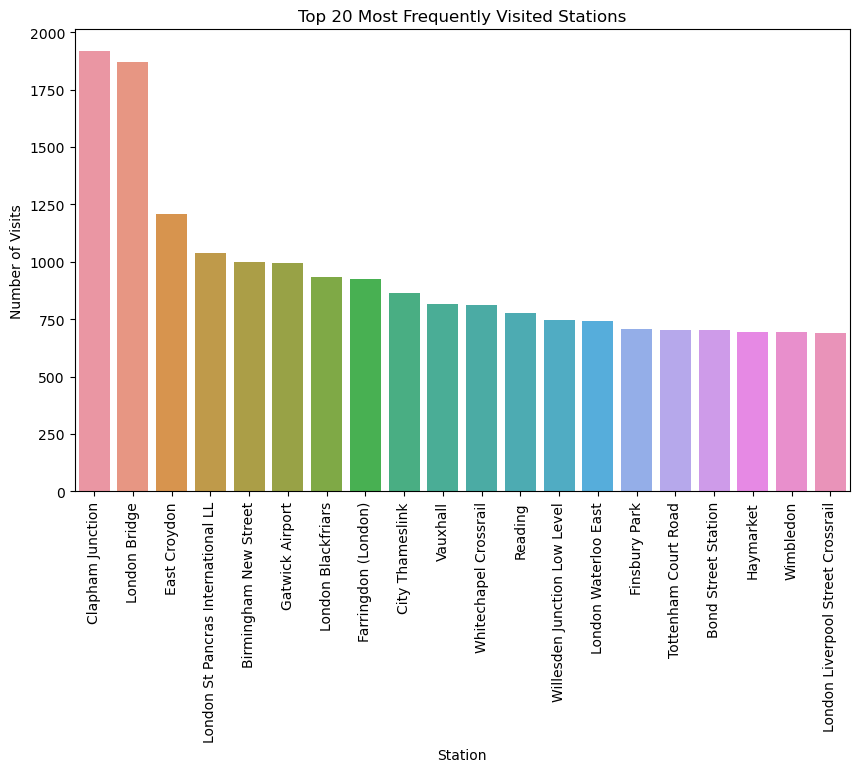

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
# Top 10 most frequently visited stations
top_stations = df_merged['StationName'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_stations.index, y=top_stations.values)
plt.title('Top 20 Most Frequently Visited Stations')
plt.xlabel('Station')
plt.ylabel('Number of Visits')
plt.xticks(rotation=90)
plt.show()

The chart shows the top 20 most frequently visited stations in the UK rail system, revealing that 13 of these stations are in London. This highlights London's central role in the rail network, driven by its approximate population of 9 million, which constitutes about 13% of the UK's total population. Major hubs like Clapham Junction and London Bridge, as well as key interchange points and commuter stations, contribute to this high traffic, reflecting the substantial demand generated by the city's large population.

Additionally, the chart underscores the importance of regional hubs such as Birmingham New Street, York, and Reading, which serve as central points for their areas, and the significance of rail connections to major airports like Gatwick. The presence of stations like City Thameslink and Whitechapel Crossrail also highlights the integration of various transport modes, providing seamless connectivity for passengers. Overall, London's dominance in the list illustrates its pivotal role in the UK's rail system, driven by its large population and economic activity.

## Duration Distribution 

In [76]:
df_merged.describe()

,service_start_date,duration (min),Latitude,Longitude,delayed
count,269708,269708.000000,256399.000000,256399.000000,269708.000000
mean,2024-07-09 10:02:17.962537472,1.485710,52.250764,-1.183624,0.112333
min,2024-07-03 00:00:00,0.050000,50.121672,-5.839077,0.000000
25%,2024-07-08 00:00:00,0.500000,51.435451,-2.275749,0.000000
50%,2024-07-10 00:00:00,1.000000,51.555208,-0.441823,0.000000
75%,2024-07-11 00:00:00,1.000000,53.222551,-0.086088,0.000000
max,2024-07-13 00:00:00,247.000000,58.590175,1.715711,1.000000
std,NaN,3.663727,1.369737,1.457310,0.315776


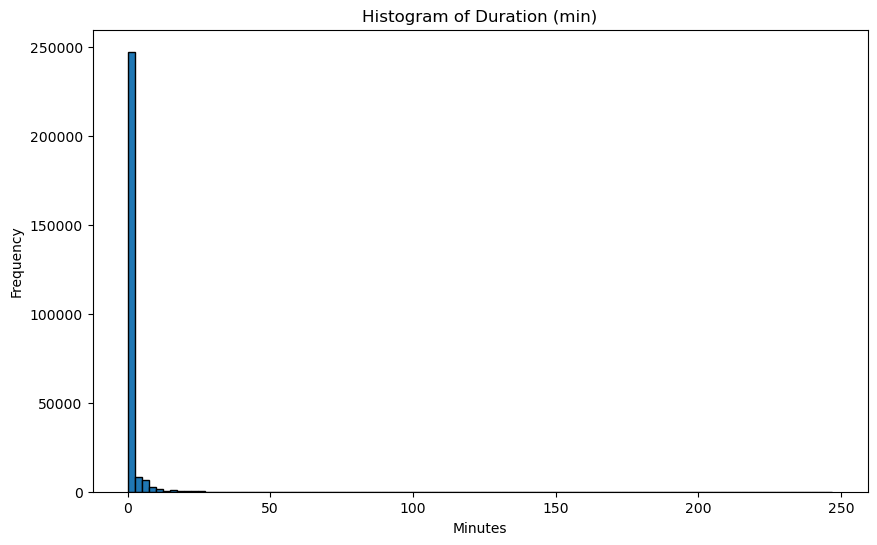

In [77]:
# Histogram for 'duration (min)'
plt.figure(figsize=(10, 6))
plt.hist(df_merged['duration (min)'], bins=100, edgecolor='black')
plt.title('Histogram of Duration (min)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

Showing true 

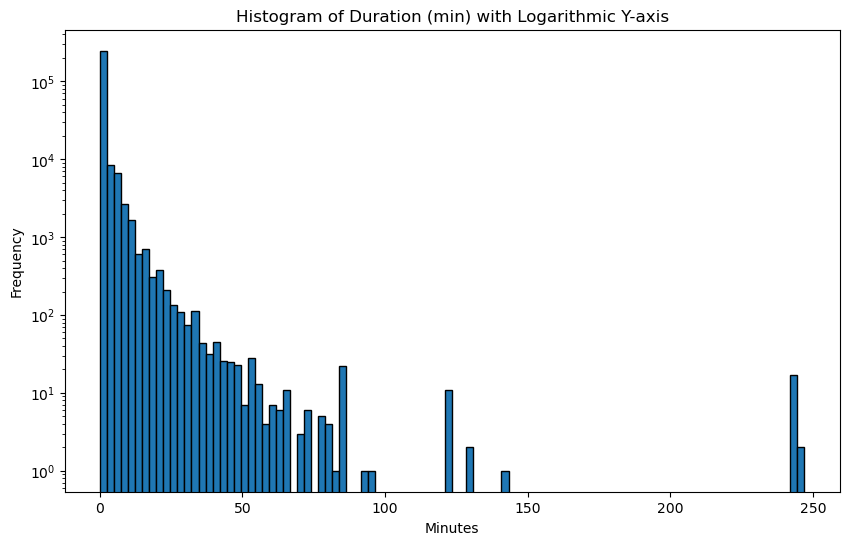

In [78]:
# Histogram for 'duration (min)' with smaller bins and logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.hist(df_merged['duration (min)'], bins=100, edgecolor='black', log=True)

plt.title('Histogram of Duration (min) with Logarithmic Y-axis')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

This histogram shows the distribution of trip durations from station to station with a logarithmic y-axis. The logarithmic scale is used to make it easier to see and understand data that has a very wide range by squeezing the numbers into a smaller, more readable format. The histogram reveals a high frequency of short trips, with the majority of trip durations clustered around the lower end, particularly between 0 and 50 minutes. There are significant drops in frequency as the duration increases, indicating that long trips are much less common. A few peaks at higher durations suggest some outliers where trips are unusually long.

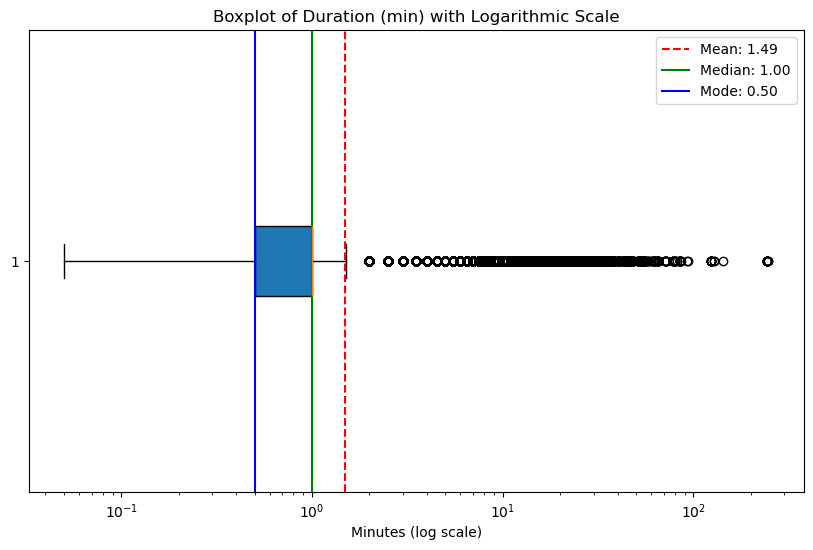

In [79]:
# Boxplot for 'duration (min)' with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.boxplot(df_merged['duration (min)'], vert=False, patch_artist=True, showfliers=True)
plt.xscale('log')

# Add mean and median lines
mean_duration = df_merged['duration (min)'].mean()
median_duration = df_merged['duration (min)'].median()
mode_duration = df_merged['duration (min)'].mode().iloc[0]

plt.axvline(mean_duration, color='r', linestyle='--', label=f'Mean: {mean_duration:.2f}')
plt.axvline(median_duration, color='g', linestyle='-', label=f'Median: {median_duration:.2f}')
plt.axvline(mode_duration, color='b', linestyle='-', label=f'Mode: {mode_duration:.2f}')

plt.title('Boxplot of Duration (min) with Logarithmic Scale')
plt.xlabel('Minutes (log scale)')
plt.legend()
plt.show()

This boxplot provides a detailed summary of the distribution, highlighting the mean, median, and mode durations. The median trip duration is 1 minute, with a mean slightly higher at 1.48 minutes, indicating that the distribution is right-skewed with a long tail of longer durations. The mode is at 0.50 minutes, showing that very short trips are most common. The presence of numerous outliers further supports the observation from the histogram that while most trips are short, there are occasional long trips that are significantly longer than the majority. The logarithmic scale on the x-axis helps to spread out the data points, making it easier to see the distribution and identify the concentration of shorter trips and the spread of longer ones.

### Overall Analysis on Trip Duration Distribution. 

The analysis of trip durations reveals that the majority of trips are very short, with most durations clustered between 0 and 50 minutes. This trend makes sense given that the majority of trips occur in densely populated cities like London, where stations are closely spaced, and the demand for frequent, short commutes is high. In such urban environments, the transportation network is designed to handle large volumes of passengers moving over short distances, facilitating quick and efficient travel between closely situated stations.

In cities like London, people often rely on the rail system for daily commutes, errands, and short-distance travel, contributing to the high frequency of brief trips. The shorter trips are reflective of the urban layout, where stations are strategically placed to maximize accessibility and convenience for city dwellers. The presence of numerous outliers with longer trip durations indicates occasional longer journeys, but these are less common. Overall, the data aligns with the expected travel patterns in a densely populated metropolitan area, emphasizing the importance of the rail network in supporting urban mobility.

## Delay Distributions

C:\Users\audre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\audre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


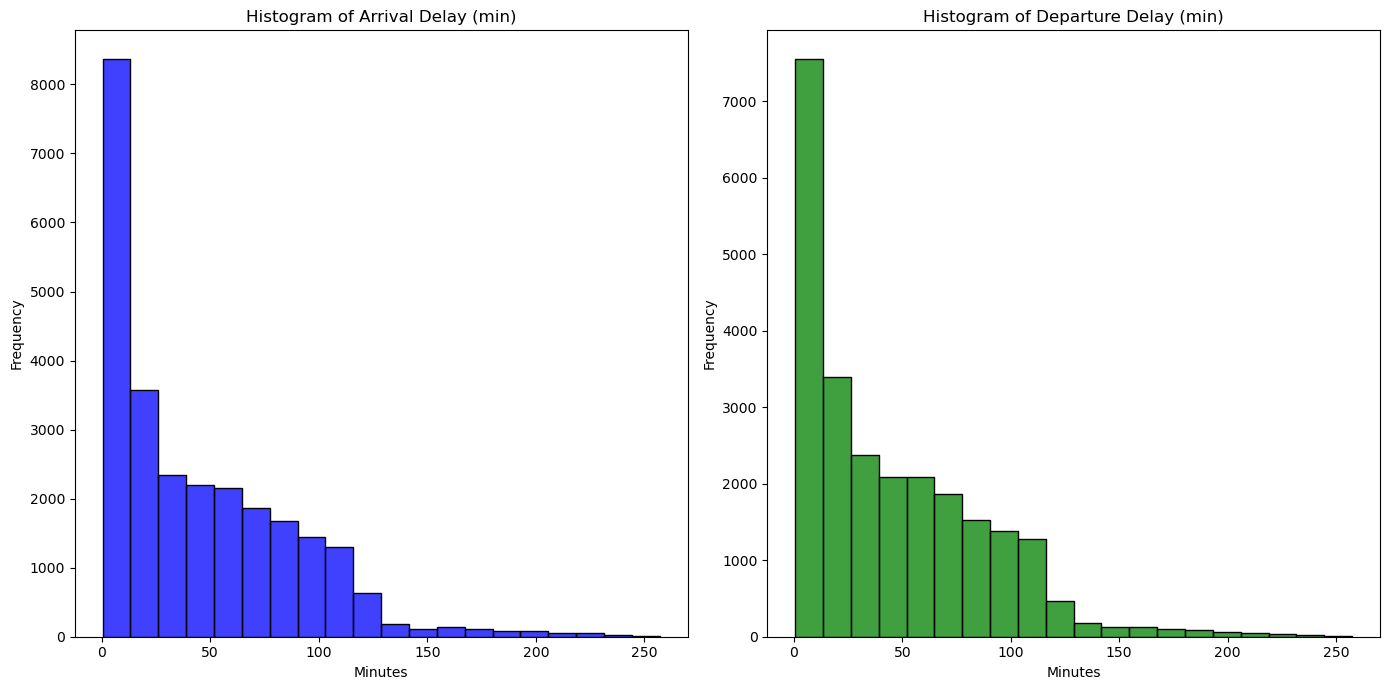

In [80]:
plt.figure(figsize=(14, 7))

# Arrival delay histogram
plt.subplot(1, 2, 1)
sns.histplot(df_delay['arrive_delay(min)'], bins=20, color='blue')
plt.title('Histogram of Arrival Delay (min)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')

# Departure delay histogram
plt.subplot(1, 2, 2)
sns.histplot(df_delay['depart_delay(min)'], bins=20, color='green')
plt.title('Histogram of Departure Delay (min)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The histograms display a high frequency of shorter delays, with most clustered between 0 and 50 minutes. As delay time increases, the frequency decreases, indicating that longer delays are less common. This right-skewed distribution shows that while shorter delays are frequent, longer delays, though less common, do occur.

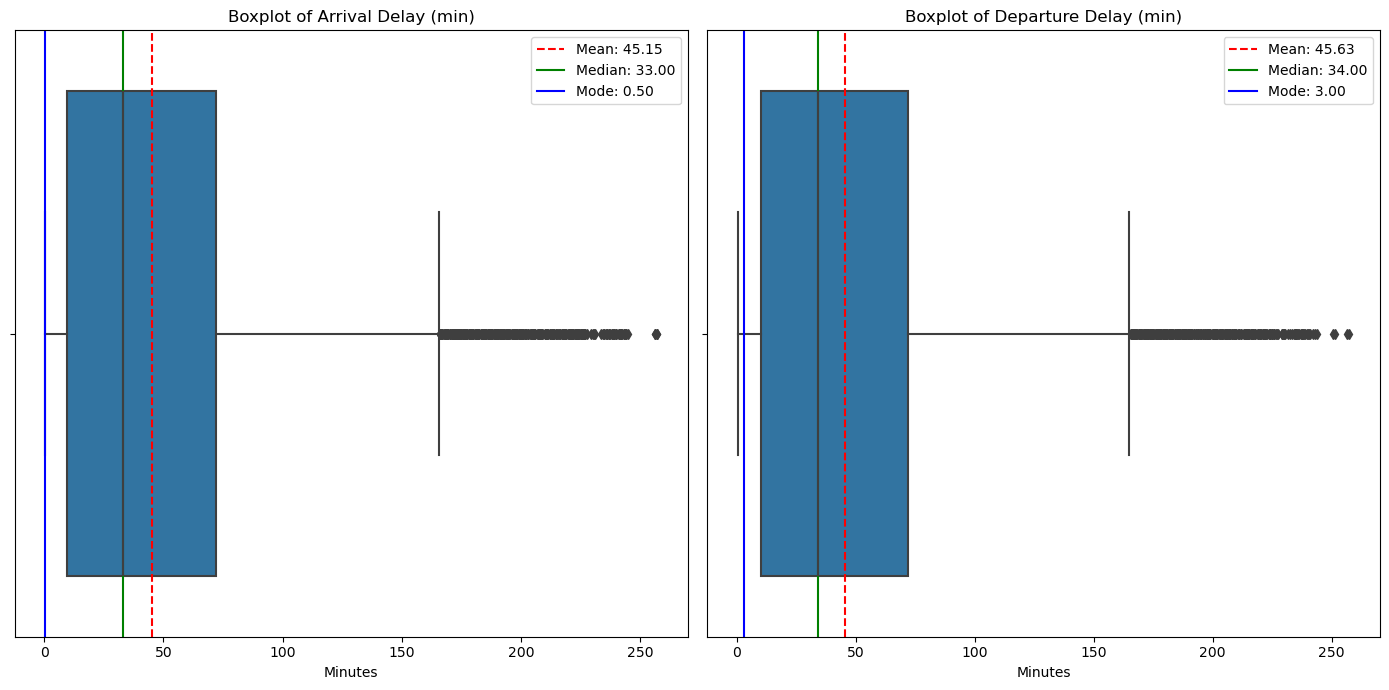

In [81]:
# Plot boxplot for arrival_delay and depart_delay
plt.figure(figsize=(14, 7))

# Adding mode 
arrival_mode = df_delay['arrive_delay(min)'].mode().iloc[0]
depart_mode = df_delay['depart_delay(min)'].mode().iloc[0]

# Arrival delay boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=df_delay['arrive_delay(min)'])
plt.title('Boxplot of Arrival Delay (min)')
plt.xlabel('Minutes')
plt.axvline(df_delay['arrive_delay(min)'].mean(), color='red', linestyle='--', label=f'Mean: {df_delay["arrive_delay(min)"].mean():.2f}')
plt.axvline(df_delay['arrive_delay(min)'].median(), color='green', linestyle='-', label=f'Median: {df_delay["arrive_delay(min)"].median():.2f}')
plt.axvline(arrival_mode, color='b', linestyle='-', label=f'Mode: {arrival_mode:.2f}')
plt.legend()

# Departure delay boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df_delay['depart_delay(min)'])
plt.title('Boxplot of Departure Delay (min)')
plt.xlabel('Minutes')
plt.axvline(df_delay['depart_delay(min)'].mean(), color='red', linestyle='--', label=f'Mean: {df_delay["depart_delay(min)"].mean():.2f}')
plt.axvline(df_delay['depart_delay(min)'].median(), color='green', linestyle='-', label=f'Median: {df_delay["depart_delay(min)"].median():.2f}')
plt.axvline(depart_mode, color='b', linestyle='-', label=f'Mode: {depart_mode:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

Both boxplots show a substantial interquartile range (IQR), indicating a significant spread in the data. The median values for both arrival and departure delays are around 34.5 minutes and 36 minutes, respectively, suggesting that half of the delays are less than these values, while the other half are greater. The mean values for arrival and departure delays are slightly higher than the median values, at 46.9 minutes and 47.41 minutes, respectively. This discrepancy indicates a right-skewed distribution, with a tail extending towards higher delay times. This right-skewed distribution aligns with the histogram analysis, confirming that while most delays are within a reasonable range, there are instances of significantly longer delays.

**Relating back to the duration distribution**

By comparing these observations with the distribution of trip duration, we can conclude that the UK's rail system experiences a higher frequency of shorter trips and moderate delays, with occasional long durations and severe delays that affect the overall average. This understanding can help in addressing the less frequent but impactful longer trips and delays to improve overall system efficiency.

# Export Desired Dataframe

In [82]:
output = df_merged.to_csv('./cleaned_data/UK_Rail_Data.csv', index=False, mode = 'w+')

In [83]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269708 entries, 0 to 269707
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   route_id                269708 non-null  object        
 1   unique_id               269708 non-null  object        
 2   service_start_date      269708 non-null  datetime64[ns]
 3   update_origin           263526 non-null  object        
 4   train_platform          269708 non-null  object        
 5   working_time_arrival    269708 non-null  object        
 6   working_time_departure  269708 non-null  object        
 7   planned_time_arrival    248113 non-null  object        
 8   planned_time_departure  247415 non-null  object        
 9   actual_arrival_time     225568 non-null  object        
 10  actual_departure_time   251924 non-null  object        
 11  platform                255214 non-null  object        
 12  is_delayed_arrival      269708

In [84]:
df_merged.describe()

,service_start_date,duration (min),Latitude,Longitude,delayed
count,269708,269708.000000,256399.000000,256399.000000,269708.000000
mean,2024-07-09 10:02:17.962537472,1.485710,52.250764,-1.183624,0.112333
min,2024-07-03 00:00:00,0.050000,50.121672,-5.839077,0.000000
25%,2024-07-08 00:00:00,0.500000,51.435451,-2.275749,0.000000
50%,2024-07-10 00:00:00,1.000000,51.555208,-0.441823,0.000000
75%,2024-07-11 00:00:00,1.000000,53.222551,-0.086088,0.000000
max,2024-07-13 00:00:00,247.000000,58.590175,1.715711,1.000000
std,NaN,3.663727,1.369737,1.457310,0.315776
